In [1]:
import numpy as np
import torch
import matplotlib.pylab as pl
import gudhi as gd
import gudhi.wasserstein as gdw
import persim
import ot
import ot.plot

In [2]:
import sys
sys.path.append('../code/')
sys.path.append('../code/ot_mmd/')
sys.path.append('../code/Latent_OT/')
from generate_data import make_data
from persistence_diagram import curve_to_diagram
from sinkhorn_iterates import sinkhorn
from linear_solver import UOT_W,LatentOT
from utils import plot2D_plan,KL,compute_kmeans_centroids
from mmdot import solve_apgd
from mmdot_mirror_descent import solve_md
from utils_mmd import kernel,MMD

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

device='cpu'
dtype = torch.DoubleTensor
print('Used device: '+device)

Used device: cpu


# 1st scenario

In [4]:
def f(x):
    return 5*(3*np.cos(x/2)-5*np.sin(-x)+np.sin(x/8)**2-np.cos(3*x))

In [5]:
x=np.linspace(1, 100, 500)
np.random.seed(0)
curve1 = f(x)+np.random.normal(0,1.6e0, size=x.shape)
curve2 = f(x)+np.random.normal(0,1.6e0, size=x.shape)

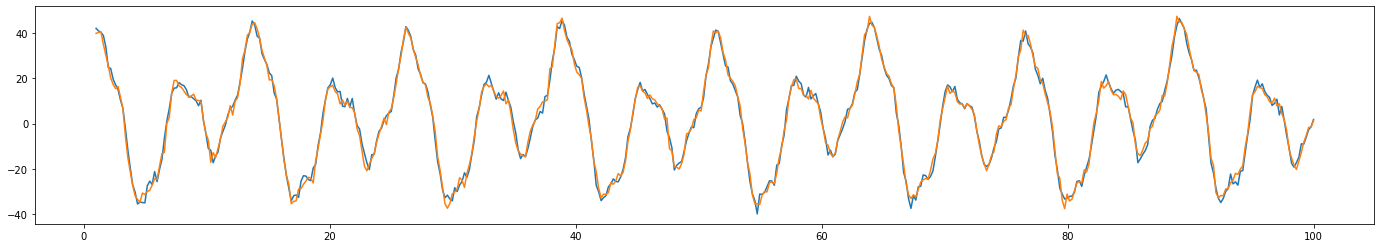

In [6]:
pl.figure(figsize=(24,4))
pl.plot(x,curve1)
pl.plot(x,curve2)

In [7]:
d1=curve_to_diagram(curve1)
d2=curve_to_diagram(curve2)

In [8]:
n=d1.shape[0]
m=d2.shape[0]
print(n,m)
a=np.ones(n+1)
b=np.ones(m+1)
a[-1],b[-1]=m,n

np.sum(a),np.sum(b)

60 63


(123.0, 123.0)

In [9]:
### Wasserstein ###
C=np.zeros((n+1,m+1))
C[:n,:m]=ot.dist(d1,d2)
C[-1,:m]=((d2[:, 1] - d2[:, 0])**2)/2
C[:n,-1]=((d1[:, 1] - d1[:, 0])**2)/2
Pw=ot.emd(a,b,C) #/(n+m)

print(np.sum(Pw))
print(np.sum(Pw[:n,:m]))
W1=np.sum(Pw*C)
print("sq Wasserstein",W1)

123.0
42.0
sq Wasserstein 114.81638980762426


In [10]:
### UOT KL ###
lam=1e0
PUOTKL=sinkhorn(torch.tensor(a),torch.tensor(b),torch.tensor(C),lam=lam,eps=2e-2,pen="kl",numiter=500).numpy()
#PUOTKL/=(n+m)
print(np.sum(PUOTKL))
print(np.sum(PUOTKL[:n,:m]))
UOTKL1=np.sum(np.multiply(PUOTKL,C))
#UOTKL1=np.sum(PUOTKL*C)+lam*KL(np.sum(PUOTKL,axis=1),a)+lam*KL(np.sum(PUOTKL,axis=0),b)
print("UOT KL",UOTKL1)

99.33079751220657
22.833430273234498
UOT KL 21.46085136499437


In [11]:
# HROT # with linear solver
Cx=np.zeros((n+1,n+1))
Cx[:n,:n]=ot.dist(d1,d1)
Cx[-1,:n]=((d1[:, 1] - d1[:, 0])**2)/2
Cx[:n,-1]=((d1[:, 1] - d1[:, 0])**2)/2
Cy=np.zeros((m+1,m+1))
Cy[:m,:m]=ot.dist(d2,d2)
Cy[-1,:m]=((d2[:, 1] - d2[:, 0])**2)/2
Cy[:m,-1]=((d2[:, 1] - d2[:, 0])**2)/2

lam=1e-1
PUOTW,Qx,Qy=UOT_W(a,b,C,lam=lam,Cx=Cx,Cy=Cy,innerplan=True)
UOTW1=np.sum(np.multiply(PUOTW,C))
#UOTW1=np.sum(np.sum(PUOTW*C)+lam*(np.sum(Qx*Cx)+np.sum(Qy*Cy)))
print(UOTW1)

21.314273445721955


In [12]:
### UOT MMD ###
Kx=torch.zeros((n+1,n+1))
Kx[:n,:n]=kernel(torch.tensor(d1),sigma=5)
Kx[-1,-1]=1
Ky=torch.zeros((m+1,m+1))
Ky[:m,:m]=kernel(torch.tensor(d2),sigma=5)
Ky[-1,-1]=1
G = {1: Kx, 2: Ky}

lam=6e-1
PUOTMMD, _ = solve_apgd(torch.tensor(C).float(), G, 
                      v = {1: torch.tensor(a).float(), 2: torch.tensor(b).float()}, max_itr=1000, lda=lam, case="unb")
PUOTMMD=PUOTMMD.numpy()
UOTMMD1=np.sum(np.multiply(PUOTMMD,C))
#UOTMMD1=np.sum(PUOTMMD*C)+lam*MMD(np.sum(PUOTMMD,axis=1),a,Kx.numpy())+lam*MMD(np.sum(PUOTMMD,axis=0),b,Ky.numpy())
print(UOTMMD1)
PUOTMMD.sum()

21.361018952604088


120.20778

In [13]:
# Latent OT #
n_anchors = 6
m_anchors = 6

Zx = compute_kmeans_centroids(d1, n_clusters=n_anchors,random_state=0)
Zy = compute_kmeans_centroids(d2, n_clusters=m_anchors,random_state=0)

Cx=np.zeros((n+1,n_anchors+1))
Cx[:n,:n_anchors]=ot.dist(d1,Zx)
Cx[-1,:n_anchors]=((Zx[:, 1] - Zx[:, 0])**2)/2
Cx[:n,-1]=((d1[:, 1] - d1[:, 0])**2)/2

Cy=np.zeros((m_anchors+1,m+1))
Cy[:m_anchors,:m]=ot.dist(Zy,d2)
Cy[-1,:m]=((d2[:, 1] - d2[:, 0])**2)/2
Cy[:m_anchors,-1]=((Zy[:, 1] - Zy[:, 0])**2)/2

Cz=np.zeros((n_anchors+1,m_anchors+1))
Cz[:n_anchors,:m_anchors]=ot.dist(Zx,Zy)
Cz[-1,:m_anchors]=((Zy[:, 1] - Zy[:, 0])**2)/2
Cz[:n_anchors,-1]=((Zx[:, 1] - Zx[:, 0])**2)/2

PLOTx,PLOTy,PLOTz=LatentOT(a,b,Cx,Cz,Cy)
#LOT1=np.sum(PLOTz*Cz)+np.sum(PLOTx*Cx)+np.sum(PLOTy*Cy)
LOT1=np.sum(PLOTz*Cz)
print(LOT1)

35.519364169803346


In [14]:
# Distinction on the diagonal or not
theta=np.array([1/np.sqrt(2),1/np.sqrt(2)])
d1p=d1@theta
d1p=d1p[:,None]*theta[None,:]
d2p=d2@theta
d2p=d2p[:,None]*theta[None,:]

Zxp=Zx@theta
Zxp=Zxp[:,None]*theta[None,:]
Zyp=Zy@theta
Zyp=Zyp[:,None]*theta[None,:]

Pws=np.diag(Pw[:n,-1])
Pwt=np.diag(Pw[-1,:m])

PUOTKLs=np.round(np.diag(PUOTKL[:n,-1]),3)
PUOTKLt=np.round(np.diag(PUOTKL[-1,:m]),3)

PUOTWs=np.round(np.diag(PUOTW[:n,-1]),3)
PUOTWt=np.round(np.diag(PUOTW[-1,:m]),3)

PUOTMMDs=np.round(np.diag(PUOTMMD[:n,-1]),3)
PUOTMMDt=np.round(np.diag(PUOTMMD[-1,:m]),3)

PUOTMMDs=np.round(np.diag(PUOTMMD[:n,-1]),3)
PUOTMMDt=np.round(np.diag(PUOTMMD[-1,:m]),3)

PLOTzs=np.round(np.diag(PLOTz[:n_anchors,-1]),3)
PLOTzt=np.round(np.diag(PLOTz[-1,:m_anchors]),3)

/tmp/ipykernel_6981/3963906225.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


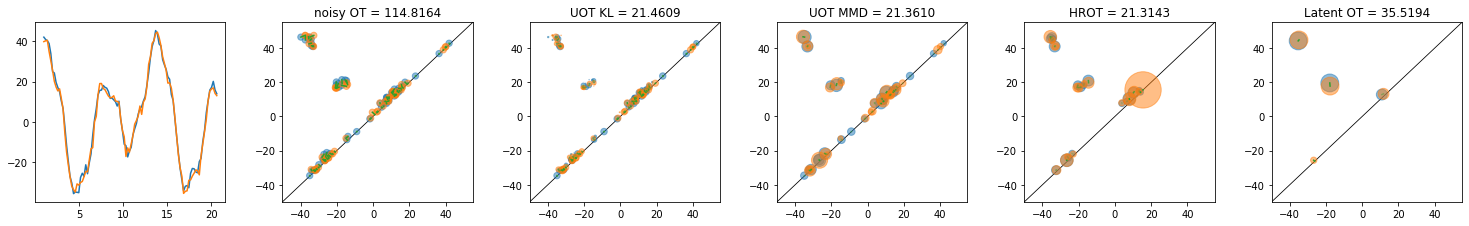

In [15]:
s=4e1
fig = pl.figure(figsize=(30,3.3))
grid = pl.GridSpec(1, 7, wspace=.3, hspace=0.3)
pl.subplot(grid[0, 0])
pl.plot(x[:100],curve1[:100])
pl.plot(x[:100],curve2[:100])

pl.subplot(grid[0, 1])
plot2D_plan(d1, d2, Pw[:n,:m], c="C2")
plot2D_plan(d1, d1p, Pws, c="C2")
plot2D_plan(d2, d2p, Pwt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.5,s=np.sum(Pw[:n,:],axis=1)*s)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.5,s=np.sum(Pw[:,:m],axis=0)*s)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=.8)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("noisy OT = %1.4f"%W1)

pl.subplot(grid[0, 2])
plot2D_plan(d1, d2, PUOTKL[:n,:m], c="C2")
plot2D_plan(d1, d1p, PUOTKLs, c="C2")
plot2D_plan(d2, d2p, PUOTKLt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.5,s=np.sum(PUOTKL[:n,:],axis=1)*s)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.5,s=np.sum(PUOTKL[:,:m],axis=0)*s)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=.8)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("UOT KL = %1.4f"%UOTKL1)

pl.subplot(grid[0, 3])
plot2D_plan(d1, d2, PUOTMMD[:n,:m], c="C2")
plot2D_plan(d1, d1p, PUOTMMDs, c="C2")
plot2D_plan(d2, d2p, PUOTMMDt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.5,s=np.sum(PUOTMMD[:n,:],axis=1)*s)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.5,s=np.sum(PUOTMMD[:,:m],axis=0)*s)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=.8)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("UOT MMD = %1.4f"%UOTMMD1)

pl.subplot(grid[0, 4])
plot2D_plan(d1, d2, PUOTW[:n,:m], c="C2")
plot2D_plan(d1, d1p, PUOTWs, c="C2")
plot2D_plan(d2, d2p, PUOTWt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.5,s=np.sum(PUOTW[:n,:],axis=1)*s)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.5,s=np.sum(PUOTW[:,:m],axis=0)*s)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=.8)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("HROT = %1.4f"%UOTW1)

pl.subplot(grid[0, 5])
plot2D_plan(Zx, Zy, PLOTz[:n_anchors,:m_anchors], c="C2")
plot2D_plan(Zx, Zxp, PLOTzs, c="C2")
plot2D_plan(Zy, Zyp, PLOTzt, c="C2")
pl.scatter(Zx[:,0],Zx[:,1],c="C0",alpha=.5,s=np.sum(PLOTz[:n_anchors,:],axis=1)*s)
pl.scatter(Zy[:,0],Zy[:,1],c="C1",alpha=.5,s=np.sum(PLOTz[:,:m_anchors],axis=0)*s)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=.8)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("Latent OT = %1.4f"%LOT1)

pl.tight_layout()

In [16]:
# Compute ground truth
xtrue=np.linspace(1, 100,1000)
curve1true = f(x)
curve2true = f(x)
d1true=curve_to_diagram(curve1true)
d2true=curve_to_diagram(curve2true)
ntrue,mtrue=d1true.shape[0],d2true.shape[0]
atrue=(50*np.ones(ntrue+1))/ntrue
btrue=(50*np.ones(mtrue+1))/mtrue
atrue[-1],btrue[-1]=50,50
Ctrue=np.zeros((ntrue+1,mtrue+1))
Ctrue[:ntrue,:mtrue]=ot.dist(d1true,d2true)
Ctrue[-1,:mtrue]=((d2true[:, 1] - d2true[:, 0])**2)/2
Ctrue[:ntrue,-1]=((d1true[:, 1] - d1true[:, 0])**2)/2
Ptrue=ot.emd(atrue,btrue,Ctrue)#/(n+m)
groundtruth1=np.sum(Ptrue*Ctrue)

d1ptrue=d1true@theta
d1ptrue=d1ptrue[:,None]*theta[None,:]
d2ptrue=d2true@theta
d2ptrue=d2ptrue[:,None]*theta[None,:]

Ptrues=np.diag(Ptrue[:n,-1])
Ptruet=np.diag(Ptrue[-1,:m])

In [17]:
d1.shape,np.sum(Pw[:n,:],axis=1).shape

((60, 2), (60,))

/tmp/ipykernel_6981/382996842.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


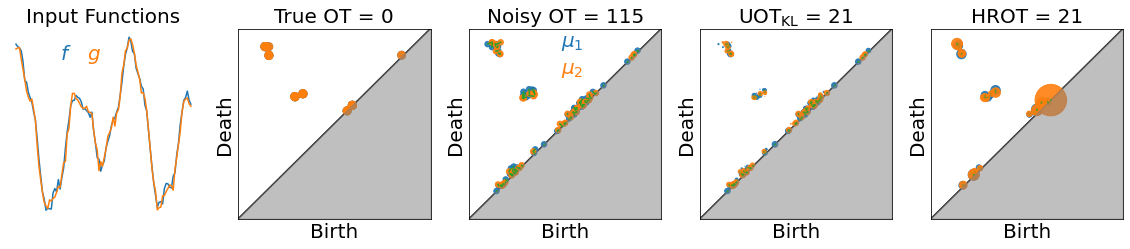

In [18]:
s=3e1
fig = pl.figure(figsize=(20,3.5))
grid = pl.GridSpec(1, 5, wspace=.2, hspace=.3)
pl.subplot(grid[0, 0])
pl.plot(x[:100],curve1[:100])
pl.plot(x[:100],curve2[:100])
pl.text(6,35,"$f$",color="C0",size=20)
pl.text(9,35,"$g$",color="C1",size=20)
pl.title("Input Functions",size=20)
pl.axis('off')

pl.subplot(grid[0, 1])
plot2D_plan(d1true, d2true, Ptrue[:n,:m], c="C2")
plot2D_plan(d1true, d1ptrue, Ptrues, c="C2")
plot2D_plan(d2true, d2ptrue, Ptruet, c="C2")
pl.scatter(d1true[:,0],d1true[:,1],c="C0",alpha=.9,s=np.sum(Ptrue[:ntrue,:],axis=1)*s)
pl.scatter(d2true[:,0],d2true[:,1],c="C1",alpha=.9,s=np.sum(Ptrue[:,:mtrue],axis=0)*s)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("True OT = %1.0f"%groundtruth1,size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)

pl.subplot(grid[0, 2])
plot2D_plan(d1, d2, Pw[:n,:m], c="C2")
plot2D_plan(d1, d1p, Pws, c="C2")
plot2D_plan(d2, d2p, Pwt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.9,s=np.sum(Pw[:n,:],axis=1)*s)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.9,s=np.sum(Pw[:,:m],axis=0)*s)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("Noisy OT = %1.0f"%W1,size=20)
pl.text(0,45,"$\mu_1$",color="C0",size=20)
pl.text(0,30,"$\mu_2$",color="C1",size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)

pl.subplot(grid[0, 3])
plot2D_plan(d1, d2, PUOTKL[:n,:m], c="C2")
plot2D_plan(d1, d1p, PUOTKLs, c="C2")
plot2D_plan(d2, d2p, PUOTKLt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.9,s=np.sum(PUOTKL[:n,:],axis=1)*s)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.9,s=np.sum(PUOTKL[:,:m],axis=0)*s)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("$\mathrm{UOT}_\\mathrm{KL}$ = %1.0f"%UOTKL1,size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)

pl.subplot(grid[0, 4])
plot2D_plan(d1, d2, PUOTW[:n,:m], c="C2")
plot2D_plan(d1, d1p, PUOTWs, c="C2")
plot2D_plan(d2, d2p, PUOTWt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.9,s=np.sum(PUOTW[:n,:],axis=1)*(s/1))
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.9,s=np.sum(PUOTW[:,:m],axis=0)*(s/1))
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("HROT = %1.0f"%UOTW1,size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)

pl.tight_layout()
pl.savefig("../Figures/PersistenceDiagram/PersistenceDiag1.pdf",bbox_inches='tight')

/tmp/ipykernel_6981/463671311.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


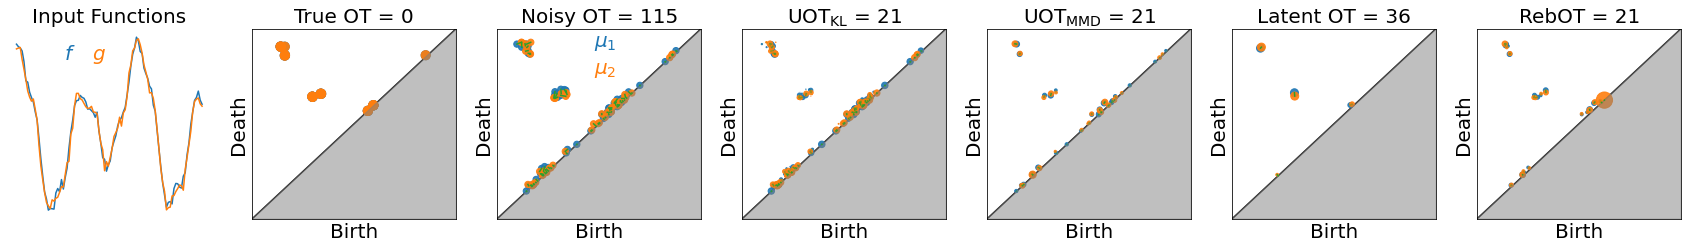

In [20]:
s=4e1
fig = pl.figure(figsize=(30,3.5))
grid = pl.GridSpec(1, 7, wspace=.2, hspace=.3)
pl.subplot(grid[0, 0])
pl.plot(x[:100],curve1[:100])
pl.plot(x[:100],curve2[:100])
pl.text(6,35,"$f$",color="C0",size=20)
pl.text(9,35,"$g$",color="C1",size=20)
pl.title("Input Functions",size=20)
pl.axis('off')

pl.subplot(grid[0, 1])
plot2D_plan(d1true, d2true, Ptrue[:n,:m], c="C2")
plot2D_plan(d1true, d1ptrue, Ptrues, c="C2")
plot2D_plan(d2true, d2ptrue, Ptruet, c="C2")
pl.scatter(d1true[:,0],d1true[:,1],c="C0",alpha=.9,s=np.sum(Ptrue[:ntrue,:],axis=1)*s)
pl.scatter(d2true[:,0],d2true[:,1],c="C1",alpha=.9,s=np.sum(Ptrue[:,:mtrue],axis=0)*s)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("True OT = %1.0f"%groundtruth1,size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)

pl.subplot(grid[0, 2])
plot2D_plan(d1, d2, Pw[:n,:m], c="C2")
plot2D_plan(d1, d1p, Pws, c="C2")
plot2D_plan(d2, d2p, Pwt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.9,s=np.sum(Pw[:n,:],axis=1)*s)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.9,s=np.sum(Pw[:,:m],axis=0)*s)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("Noisy OT = %1.0f"%W1,size=20)
pl.text(0,45,"$\mu_1$",color="C0",size=20)
pl.text(0,30,"$\mu_2$",color="C1",size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)

pl.subplot(grid[0, 3])
plot2D_plan(d1, d2, PUOTKL[:n,:m], c="C2")
plot2D_plan(d1, d1p, PUOTKLs, c="C2")
plot2D_plan(d2, d2p, PUOTKLt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.9,s=np.sum(PUOTKL[:n,:],axis=1)*s)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.9,s=np.sum(PUOTKL[:,:m],axis=0)*s)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("$\mathrm{UOT}_\\mathrm{KL}$ = %1.0f"%UOTKL1,size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)

pl.subplot(grid[0, 4])
plot2D_plan(d1, d2, PUOTMMD[:n,:m], c="C2")
plot2D_plan(d1, d1p, PUOTMMDs, c="C2")
plot2D_plan(d2, d2p, PUOTMMDt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.9,s=np.sum(PUOTMMD[:n,:],axis=1)*(s/5))
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.9,s=np.sum(PUOTMMD[:,:m],axis=0)*(s/5))
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("$\mathrm{UOT}_\mathrm{MMD}$ = %1.0f"%UOTMMD1,size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)

pl.subplot(grid[0, 5])
plot2D_plan(Zx, Zy, PLOTz[:n_anchors,:m_anchors], c="C2")
plot2D_plan(Zx, Zxp, PLOTzs, c="C2")
plot2D_plan(Zy, Zyp, PLOTzt, c="C2")
pl.scatter(Zx[:,0],Zx[:,1],c="C0",alpha=.9,s=np.sum(PLOTz[:n_anchors,:],axis=1)*(s/5))
pl.scatter(Zy[:,0],Zy[:,1],c="C1",alpha=.9,s=np.sum(PLOTz[:,:m_anchors],axis=0)*(s/5))
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("Latent OT = %1.0f"%LOT1,size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)

pl.subplot(grid[0, 6])
plot2D_plan(d1, d2, PUOTW[:n,:m], c="C2")
plot2D_plan(d1, d1p, PUOTWs, c="C2")
plot2D_plan(d2, d2p, PUOTWt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.9,s=np.sum(PUOTW[:n,:],axis=1)*(s/5))
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.9,s=np.sum(PUOTW[:,:m],axis=0)*(s/5))
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("RebOT = %1.0f"%UOTW1,size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)



pl.tight_layout()
pl.savefig("../Figures/PersistenceDiagram/PersistenceDiag1bis.pdf",bbox_inches='tight')

3653.5385301922825


/tmp/ipykernel_6228/671269181.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


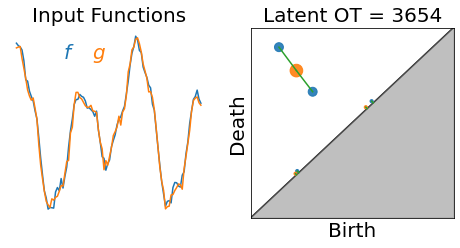

In [30]:
# Latent OT wrong n anchors#
n_anchors = 4
m_anchors = 4

Zx = compute_kmeans_centroids(d1, n_clusters=n_anchors,random_state=0)
Zy = compute_kmeans_centroids(d2, n_clusters=m_anchors,random_state=0)

Cx=np.zeros((n+1,n_anchors+1))
Cx[:n,:n_anchors]=ot.dist(d1,Zx)
Cx[-1,:n_anchors]=((Zx[:, 1] - Zx[:, 0])**2)/2
Cx[:n,-1]=((d1[:, 1] - d1[:, 0])**2)/2

Cy=np.zeros((m_anchors+1,m+1))
Cy[:m_anchors,:m]=ot.dist(Zy,d2)
Cy[-1,:m]=((d2[:, 1] - d2[:, 0])**2)/2
Cy[:m_anchors,-1]=((Zy[:, 1] - Zy[:, 0])**2)/2

Cz=np.zeros((n_anchors+1,m_anchors+1))
Cz[:n_anchors,:m_anchors]=ot.dist(Zx,Zy)
Cz[-1,:m_anchors]=((Zy[:, 1] - Zy[:, 0])**2)/2
Cz[:n_anchors,-1]=((Zx[:, 1] - Zx[:, 0])**2)/2

PLOTx,PLOTy,PLOTz=LatentOT(a,b,Cx,Cz,Cy,solver="ECOS")
LOT1bis=np.sum(PLOTz*Cz)
#LOT1bis=np.sum(PLOTz*Cz)+np.sum(PLOTx*Cx)+np.sum(PLOTy*Cy)
print(LOT1bis)

Zxp=Zx@theta
Zxp=Zxp[:,None]*theta[None,:]
Zyp=Zy@theta
Zyp=Zyp[:,None]*theta[None,:]
PLOTzs=np.round(np.diag(PLOTz[:n_anchors,-1]),3)
PLOTzt=np.round(np.diag(PLOTz[-1,:m_anchors]),3)

s=1e1
fig = pl.figure(figsize=(8,3.5))
grid = pl.GridSpec(1, 2, wspace=.2, hspace=.3)
pl.subplot(grid[0, 0])
pl.plot(x[:100],curve1[:100])
pl.plot(x[:100],curve2[:100])
pl.text(6,35,"$f$",color="C0",size=20)
pl.text(9,35,"$g$",color="C1",size=20)
pl.title("Input Functions",size=20)
pl.axis('off')

pl.subplot(grid[0, 1])
plot2D_plan(Zx, Zy, PLOTz[:n_anchors,:m_anchors], c="C2")
plot2D_plan(Zx, Zxp, PLOTzs, c="C2")
plot2D_plan(Zy, Zyp, PLOTzt, c="C2")
pl.scatter(Zx[:,0],Zx[:,1],c="C0",alpha=.9,s=np.sum(PLOTz[:n_anchors,:],axis=1)*s)
pl.scatter(Zy[:,0],Zy[:,1],c="C1",alpha=.9,s=np.sum(PLOTz[:,:m_anchors],axis=0)*s)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("Latent OT = %1.0f"%LOT1bis,size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)

pl.tight_layout()
pl.savefig("../Figures/PersistenceDiagram/PersistenceDiag1LOT.pdf",bbox_inches='tight')

# Scenario 2

In [21]:
def f(x):
    return 35*np.sin(x)

def g(x):
    return 30*np.ones(x.shape[0])
    #return np.sin(x)-5

In [22]:
x=np.linspace(1, 100, 300)
np.random.seed(0)
curve1 = f(x)+np.random.normal(0,4e0, size=x.shape)
curve2 = g(x)+np.random.normal(0,1e0, size=x.shape)

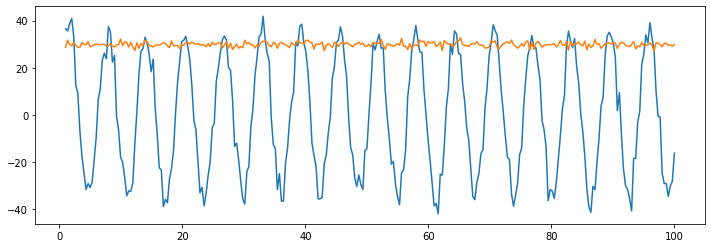

In [23]:
pl.figure(figsize=(12,4))
pl.plot(x,curve1)
pl.plot(x,curve2)

In [24]:
d1=curve_to_diagram(curve1)#+np.array([10,10])

d2=curve_to_diagram(curve2)

In [25]:
#d1=np.vstack((d1,d1[-1,:]))

In [26]:
n=d1.shape[0]
m=d2.shape[0]
print(n,m)

a=np.ones(n+1)
b=np.ones(m+1)
a[-1],b[-1]=m,n

40 96


In [27]:
np.sum(a),np.sum(b)

(136.0, 136.0)

In [28]:
### Wasserstein ###
C=np.zeros((n+1,m+1))
C[:n,:m]=ot.dist(d1,d2)
C[-1,:m]=((d2[:, 1] - d2[:, 0])**2)/2
C[:n,-1]=((d1[:, 1] - d1[:, 0])**2)/2
Pw=ot.emd(a,b,C)
print(np.sum(Pw[:n,:m]))
W2=np.sum(Pw*C)
print("sq Wasserstein",W2)
Pw.sum()

5.0
sq Wasserstein 43921.42862294117


136.0

In [29]:
### UOT KL ###
lam=1.15e4
PUOTKL=sinkhorn(torch.tensor(a),torch.tensor(b),torch.tensor(C),lam=lam,eps=5e0,pen="kl",numiter=500).numpy()
#PUOTKL/=(n+m)
print(np.sum(PUOTKL))
print(np.sum(PUOTKL[:n,:m]))
UOTKL2=np.sum(np.multiply(PUOTKL,C))
#UOTKL2=np.sum(PUOTKL*C)+lam*KL(np.sum(PUOTKL,axis=1),a)+lam*KL(np.sum(PUOTKL,axis=0),b)
print("UOT KL",UOTKL2)

lam=1e1
PUOTKL2=sinkhorn(torch.tensor(a),torch.tensor(b),torch.tensor(C),lam=lam,eps=5e0,pen="kl",numiter=500).numpy()
#PUOTKL/=(n+m)
print(np.sum(PUOTKL2))
print(np.sum(PUOTKL2[:n,:m]))
UOTKL22=np.sum(np.multiply(PUOTKL2,C))
#UOTKL22=np.sum(PUOTKL*C)+lam*KL(np.sum(PUOTKL,axis=1),a)+lam*KL(np.sum(PUOTKL,axis=0),b)
print("UOT KL",UOTKL22)

133.08069075148282
5.58442575364632
UOT KL 34776.71866378056
121.82715784994664
18.60207847560283
UOT KL 275.94113241467176


In [30]:
# HROT # with linear solver
Cx=np.zeros((n+1,n+1))
Cx[:n,:n]=ot.dist(d1,d1)
Cx[-1,:n]=((d1[:, 1] - d1[:, 0])**2)/2
Cx[:n,-1]=((d1[:, 1] - d1[:, 0])**2)/2
Cy=np.zeros((m+1,m+1))
Cy[:m,:m]=ot.dist(d2,d2)
Cy[-1,:m]=((d2[:, 1] - d2[:, 0])**2)/2
Cy[:m,-1]=((d2[:, 1] - d2[:, 0])**2)/2

lam=2e0
#lam=1e-1
PUOTW,Qx,Qy=UOT_W(a,b,C,lam=lam,Cx=Cx,Cy=Cy,innerplan=True)
UOTW2=np.sum(np.multiply(PUOTW,C))
#UOTW2=np.sum(PUOTW*C)+lam*(np.sum(Qx*Cx)+np.sum(Qy*Cy))
print(UOTW2)

34795.800523251404


In [31]:
### UOT MMD ###
Kx=torch.zeros((n+1,n+1))
Kx[:n,:n]=kernel(torch.tensor(d1),sigma=5)
Kx[-1,-1]=1
Ky=torch.zeros((m+1,m+1))
Ky[:m,:m]=kernel(torch.tensor(d2),sigma=5)
Ky[-1,-1]=1
G = {1: Kx, 2: Ky}

lam=9.5e2
PUOTMMD, _ = solve_apgd(torch.tensor(C).float(), G, 
                      v = {1: torch.tensor(a).float(), 2: torch.tensor(b).float()}, max_itr=1000, lda=lam, case="unb")
PUOTMMD=PUOTMMD.numpy()
UOTMMD2=np.sum(np.multiply(PUOTMMD,C))
#UOTMMD2=np.sum(PUOTMMD*C)+lam*MMD(np.sum(PUOTMMD,axis=1),a,Kx.numpy())+lam*MMD(np.sum(PUOTMMD,axis=0),b,Ky.numpy())
print(UOTMMD2)

34850.35851395613


In [32]:
# Latent OT #
n_anchors = 40
m_anchors = 96

Zx = compute_kmeans_centroids(d1, n_clusters=n_anchors,random_state=0)
Zy = compute_kmeans_centroids(d2, n_clusters=m_anchors,random_state=0)

Cx=np.zeros((n+1,n_anchors+1))
Cx[:n,:n_anchors]=ot.dist(d1,Zx)
Cx[-1,:n_anchors]=((Zx[:, 1] - Zx[:, 0])**2)/2
Cx[:n,-1]=((d1[:, 1] - d1[:, 0])**2)/2

Cy=np.zeros((m_anchors+1,m+1))
Cy[:m_anchors,:m]=ot.dist(Zy,d2)
Cy[-1,:m]=((d2[:, 1] - d2[:, 0])**2)/2
Cy[:m_anchors,-1]=((Zy[:, 1] - Zy[:, 0])**2)/2

Cz=np.zeros((n_anchors+1,m_anchors+1))
Cz[:n_anchors,:m_anchors]=ot.dist(Zx,Zy)
Cz[-1,:m_anchors]=((Zy[:, 1] - Zy[:, 0])**2)/2
Cz[:n_anchors,-1]=((Zx[:, 1] - Zx[:, 0])**2)/2


PLOTx, PLOTy, PLOTz=LatentOT(a,b,Cx,Cz,Cy)
LOT2=np.sum(PLOTz*Cz)
#LOT2=np.sum(PLOTz*Cz)+np.sum(PLOTx*Cx)+np.sum(PLOTy*Cy)
print(LOT2)

21915.365956998347


In [33]:
# Distinction on the diagonal or not
theta=np.array([1/np.sqrt(2),1/np.sqrt(2)])
d1p=d1@theta
d1p=d1p[:,None]*theta[None,:]
d2p=d2@theta
d2p=d2p[:,None]*theta[None,:]

Zxp=Zx@theta
Zxp=Zxp[:,None]*theta[None,:]
Zyp=Zy@theta
Zyp=Zyp[:,None]*theta[None,:]

Pws=np.diag(Pw[:n,-1])
Pwt=np.diag(Pw[-1,:m])

PUOTKLs=np.round(np.diag(PUOTKL[:n,-1]),3)
PUOTKLt=np.round(np.diag(PUOTKL[-1,:m]),3)
PUOTKL2s=np.round(np.diag(PUOTKL2[:n,-1]),3)
PUOTKL2t=np.round(np.diag(PUOTKL2[-1,:m]),3)

PUOTWs=np.round(np.diag(PUOTW[:n,-1]),3)
PUOTWt=np.round(np.diag(PUOTW[-1,:m]),3)

PUOTMMDs=np.round(np.diag(PUOTMMD[:n,-1]),3)
PUOTMMDt=np.round(np.diag(PUOTMMD[-1,:m]),3)

PUOTMMDs=np.round(np.diag(PUOTMMD[:n,-1]),3)
PUOTMMDt=np.round(np.diag(PUOTMMD[-1,:m]),3)

PLOTzs=np.round(np.diag(PLOTz[:n_anchors,-1]),3)
PLOTzt=np.round(np.diag(PLOTz[-1,:m_anchors]),3)

/tmp/ipykernel_6981/1779083810.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


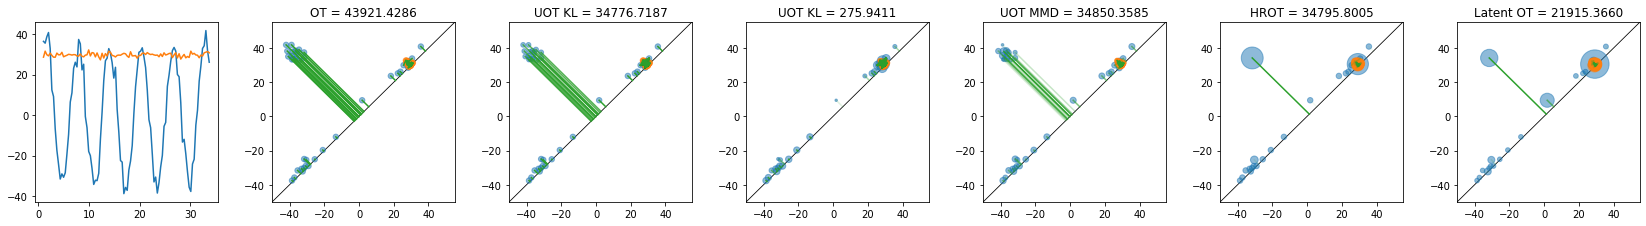

In [34]:
s=3e1
fig = pl.figure(figsize=(33,3.3))
grid = pl.GridSpec(1, 8, wspace=.3, hspace=0.3)
pl.subplot(grid[0, 0])
pl.plot(x[:100],curve1[:100])
pl.plot(x[:100],curve2[:100])

pl.subplot(grid[0, 1])
plot2D_plan(d1, d2, Pw[:n,:m]*s, c="C2")
plot2D_plan(d1, d1p, Pws, c="C2")
plot2D_plan(d2, d2p, Pwt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.5,s=np.sum(Pw[:n,:],axis=1)*s)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.5,s=np.sum(Pw[:,:m],axis=0)*s)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=.8)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("OT = %1.4f"%W2)

pl.subplot(grid[0, 2])
plot2D_plan(d1, d2, PUOTKL[:n,:m]*s, c="C2")
plot2D_plan(d1, d1p, PUOTKLs, c="C2")
plot2D_plan(d2, d2p, PUOTKLt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.5,s=np.sum(PUOTKL[:n,:],axis=1)*s)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.5,s=np.sum(PUOTKL[:,:m],axis=0)*s)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=.8)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("UOT KL = %1.4f"%UOTKL2)

pl.subplot(grid[0, 3])
plot2D_plan(d1, d2, PUOTKL2[:n,:m]*s, c="C2")
plot2D_plan(d1, d1p, PUOTKL2s, c="C2")
plot2D_plan(d2, d2p, PUOTKL2t, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.5,s=np.sum(PUOTKL2[:n,:],axis=1)*s)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.5,s=np.sum(PUOTKL2[:,:m],axis=0)*s)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=.8)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("UOT KL = %1.4f"%UOTKL22)

pl.subplot(grid[0, 4])
plot2D_plan(d1, d2, PUOTMMD[:n,:m], c="C2")
plot2D_plan(d1, d1p, PUOTMMDs, c="C2")
plot2D_plan(d2, d2p, PUOTMMDt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.5,s=np.sum(PUOTMMD[:n,:],axis=1)*s)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.5,s=np.sum(PUOTMMD[:,:m],axis=0)*s)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=.8)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("UOT MMD = %1.4f"%UOTMMD2)

pl.subplot(grid[0, 5])
plot2D_plan(d1, d2, PUOTW[:n,:m]*s, c="C2")
plot2D_plan(d1, d1p, PUOTWs, c="C2")
plot2D_plan(d2, d2p, PUOTWt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.5,s=np.sum(PUOTW[:n,:],axis=1)*s)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.5,s=np.sum(PUOTW[:,:m],axis=0)*s)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=.8)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("HROT = %1.4f"%UOTW2)

pl.subplot(grid[0, 6])
plot2D_plan(Zx, Zy, PLOTz[:n_anchors,:m_anchors], c="C2")
plot2D_plan(Zx, Zxp, PLOTzs, c="C2")
plot2D_plan(Zy, Zyp, PLOTzt, c="C2")
pl.scatter(Zx[:,0],Zx[:,1],c="C0",alpha=.5,s=np.sum(PLOTz[:n_anchors,:],axis=1)*s)
pl.scatter(Zy[:,0],Zy[:,1],c="C1",alpha=.5,s=np.sum(PLOTz[:,:m_anchors],axis=0)*s)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=.8)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("Latent OT = %1.4f"%LOT2)

pl.tight_layout()

In [35]:
xtrue=np.linspace(1, 100, 30000)
curve1true = f(xtrue)
curve2true = g(xtrue)
d1true=curve_to_diagram(curve1true)
d2true=curve_to_diagram(curve2true)
#d1true=np.delete(d1true,10,0)
#d1true=d1true[:1,:]
ntrue,mtrue=d1true.shape[0],d2true.shape[0]
atrue=np.ones(ntrue+1)
btrue=np.ones(mtrue+1)
atrue[-1],btrue[-1]=mtrue,ntrue
Ctrue=np.zeros((ntrue+1,mtrue+1))
Ctrue[:ntrue,:mtrue]=ot.dist(d1true,d2true)
Ctrue[-1,:mtrue]=((d2true[:, 1] - d2true[:, 0])**2)/2
Ctrue[:ntrue,-1]=((d1true[:, 1] - d1true[:, 0])**2)/2
Ptrue=ot.emd(atrue,btrue,Ctrue)#/(n+m)
groundtruth2=np.sum(Ptrue*Ctrue)
print(groundtruth2)

d1ptrue=d1true@theta
d1ptrue=d1ptrue[:,None]*theta[None,:]
d2ptrue=d2true@theta
d2ptrue=d2ptrue[:,None]*theta[None,:]

Ptrues=np.diag(Ptrue[:n,-1])
Ptruet=np.diag(Ptrue[-1,:m])


39215.36069874799


In [36]:
#d1true.shape,d1.shape

/tmp/ipykernel_6981/2662030765.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


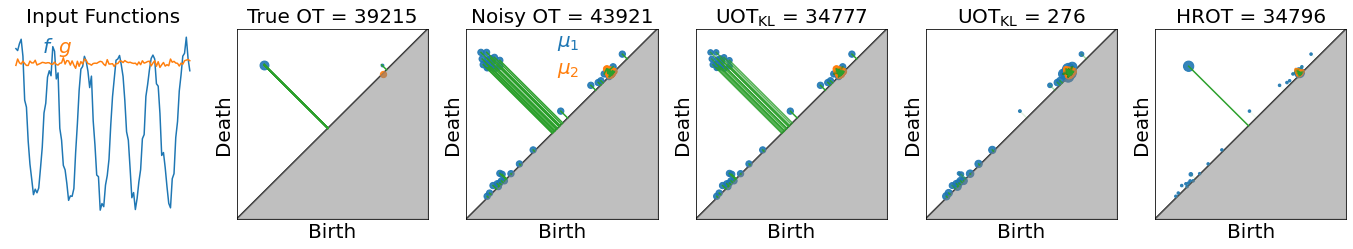

In [37]:
s=4e1
fig = pl.figure(figsize=(24,3.5))
grid = pl.GridSpec(1, 6, wspace=.2, hspace=.3)
pl.subplot(grid[0, 0])
pl.plot(x[:100],curve1[:100])
pl.plot(x[:100],curve2[:100])
pl.text(6,35,"$f$",color="C0",size=20)
pl.text(9,35,"$g$",color="C1",size=20)
pl.title("Input Functions",size=20)
pl.axis('off')

pl.subplot(grid[0, 1])
plot2D_plan(d1true, d2true, Ptrue[:n,:m], c="C2")
plot2D_plan(d1true, d1ptrue, Ptrues, c="C2")
plot2D_plan(d2true, d2ptrue, Ptruet, c="C2")
#pl.scatter(d1true[,0],d1true[,1],c="C0",alpha=.9,s=np.sum(Ptrue[:ntrue,:],axis=1)*s)
pl.scatter(d1true[0,0],d1true[0,1],c="C0",alpha=.9,s=2*s)
pl.scatter(d1true[-2,0],d1true[-2,1],c="C0",alpha=.9,s=.2*s)
pl.scatter(d2true[:,0],d2true[:,1],c="C1",alpha=.9,s=np.sum(Ptrue[:,:mtrue],axis=0)*s)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("True OT = %1.0f"%groundtruth2,size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)

pl.subplot(grid[0, 2])
plot2D_plan(d1, d2, Pw[:n,:m], c="C2")
plot2D_plan(d1, d1p, Pws, c="C2")
plot2D_plan(d2, d2p, Pwt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.9,s=np.sum(Pw[:n,:],axis=1)*s)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.9,s=np.sum(Pw[:,:m],axis=0)*s)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("Noisy OT = %1.0f"%W2,size=20)
pl.text(0,45,"$\mu_1$",color="C0",size=20)
pl.text(0,30,"$\mu_2$",color="C1",size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)

pl.subplot(grid[0, 3])
plot2D_plan(d1, d2, PUOTKL[:n,:m], c="C2")
plot2D_plan(d1, d1p, PUOTKLs, c="C2")
plot2D_plan(d2, d2p, PUOTKLt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.9,s=np.sum(PUOTKL[:n,:],axis=1)*s)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.9,s=np.sum(PUOTKL[:,:m],axis=0)*s)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("$\mathrm{UOT}_\\mathrm{KL}$ = %1.0f"%UOTKL2,size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)

pl.subplot(grid[0, 4])
plot2D_plan(d1, d2, PUOTKL2[:n,:m], c="C2")
plot2D_plan(d1, d1p, PUOTKL2s, c="C2")
plot2D_plan(d2, d2p, PUOTKL2t, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.9,s=np.sum(PUOTKL2[:n,:],axis=1)*s)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.9,s=np.sum(PUOTKL2[:,:m],axis=0)*s)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("$\mathrm{UOT}_\\mathrm{KL}$ = %1.0f"%UOTKL22,size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)

pl.subplot(grid[0, 5])
plot2D_plan(d1, d2, PUOTW[:n,:m], c="C2")
plot2D_plan(d1, d1p, PUOTWs, c="C2")
plot2D_plan(d2, d2p, PUOTWt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.9,s=np.sum(PUOTW[:n,:],axis=1)*(s/6))
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.9,s=np.sum(PUOTW[:,:m],axis=0)*(s/6))
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("HROT = %1.0f"%UOTW2,size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)

pl.tight_layout()
pl.savefig("../Figures/PersistenceDiagram/PersistenceDiag2.pdf",bbox_inches='tight')

/tmp/ipykernel_6981/4269792861.py:124: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  pl.tight_layout()


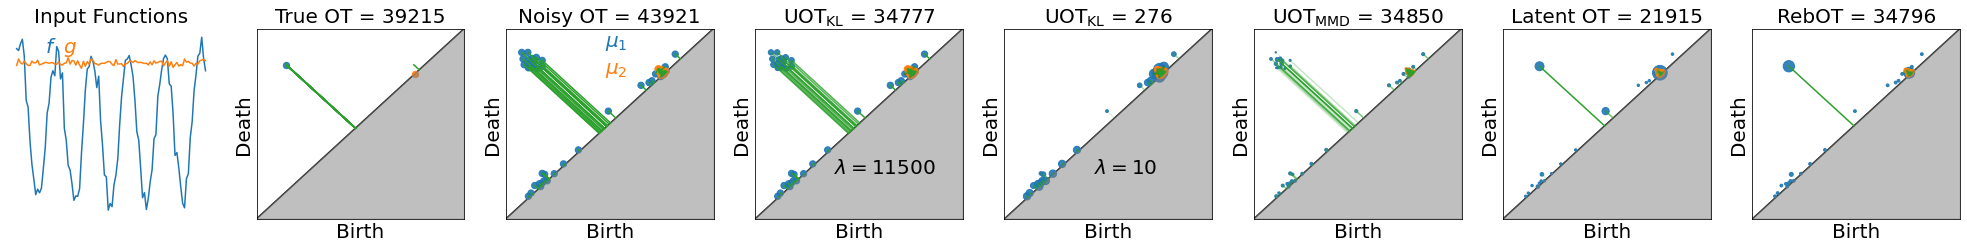

In [40]:
s=4e1
fig = pl.figure(figsize=(35,3.5))
grid = pl.GridSpec(1, 8, wspace=.2, hspace=.3)
pl.subplot(grid[0, 0])
pl.plot(x[:100],curve1[:100])
pl.plot(x[:100],curve2[:100])
pl.text(6,35,"$f$",color="C0",size=20)
pl.text(9,35,"$g$",color="C1",size=20)
pl.title("Input Functions",size=20)
pl.axis('off')

pl.subplot(grid[0, 1])
plot2D_plan(d1true, d2true, Ptrue[:n,:m], c="C2")
plot2D_plan(d1true, d1ptrue, Ptrues, c="C2")
plot2D_plan(d2true, d2ptrue, Ptruet, c="C2")
#pl.scatter(d1true[:,0],d1true[:,1],c="C0",alpha=.9,s=np.sum(Ptrue[:ntrue,:],axis=1)*s)
pl.scatter(d1true[0,0],d1true[0,1],c="C0",alpha=.9,s=1*s)
pl.scatter(d2true[:,0],d2true[:,1],c="C1",alpha=.9,s=np.sum(Ptrue[:,:mtrue],axis=0)*s)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("True OT = %1.0f"%groundtruth2,size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)

pl.subplot(grid[0, 2])
plot2D_plan(d1, d2, Pw[:n,:m], c="C2")
plot2D_plan(d1, d1p, Pws, c="C2")
plot2D_plan(d2, d2p, Pwt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.9,s=np.sum(Pw[:n,:],axis=1)*s)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.9,s=np.sum(Pw[:,:m],axis=0)*s)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("Noisy OT = %1.0f"%W2,size=20)
pl.text(0,45,"$\mu_1$",color="C0",size=20)
pl.text(0,30,"$\mu_2$",color="C1",size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)

pl.subplot(grid[0, 3])
plot2D_plan(d1, d2, PUOTKL[:n,:m], c="C2")
plot2D_plan(d1, d1p, PUOTKLs, c="C2")
plot2D_plan(d2, d2p, PUOTKLt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.9,s=np.sum(PUOTKL[:n,:],axis=1)*s)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.9,s=np.sum(PUOTKL[:,:m],axis=0)*s)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.text(-10,-25,"$\lambda = 11500$",size=20)
pl.title("$\mathrm{UOT}_\\mathrm{KL}$ = %1.0f"%UOTKL2,size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)

pl.subplot(grid[0, 4])
plot2D_plan(d1, d2, PUOTKL2[:n,:m], c="C2")
plot2D_plan(d1, d1p, PUOTKL2s, c="C2")
plot2D_plan(d2, d2p, PUOTKL2t, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.9,s=np.sum(PUOTKL2[:n,:],axis=1)*s)
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.9,s=np.sum(PUOTKL2[:,:m],axis=0)*s)
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.text(-5,-25,"$\lambda = 10$",size=20)
pl.title("$\mathrm{UOT}_\\mathrm{KL}$ = %1.0f"%UOTKL22,size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)

pl.subplot(grid[0, 5])
plot2D_plan(d1, d2, PUOTMMD[:n,:m], c="C2")
plot2D_plan(d1, d1p, PUOTMMDs, c="C2")
plot2D_plan(d2, d2p, PUOTMMDt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.9,s=np.sum(PUOTMMD[:n,:],axis=1)*(s/5))
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.9,s=np.sum(PUOTMMD[:,:m],axis=0)*(s/5))
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("$\mathrm{UOT}_\mathrm{MMD}$ = %1.0f"%UOTMMD2,size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)

pl.subplot(grid[0, 6])
plot2D_plan(Zx, Zy, PLOTz[:n_anchors,:m_anchors], c="C2")
plot2D_plan(Zx, Zxp, PLOTzs, c="C2")
plot2D_plan(Zy, Zyp, PLOTzt, c="C2")
pl.scatter(Zx[:,0],Zx[:,1],c="C0",alpha=.9,s=np.sum(PLOTz[:n_anchors,:],axis=1)*(s/5))
pl.scatter(Zy[:,0],Zy[:,1],c="C1",alpha=.9,s=np.sum(PLOTz[:,:m_anchors],axis=0)*(s/5))
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("Latent OT = %1.0f"%LOT2,size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)


pl.subplot(grid[0, 7])
plot2D_plan(d1, d2, PUOTW[:n,:m], c="C2")
plot2D_plan(d1, d1p, PUOTWs, c="C2")
plot2D_plan(d2, d2p, PUOTWt, c="C2")
pl.scatter(d1[:,0],d1[:,1],c="C0",alpha=.9,s=np.sum(PUOTW[:n,:],axis=1)*(s/5))
pl.scatter(d2[:,0],d2[:,1],c="C1",alpha=.9,s=np.sum(PUOTW[:,:m],axis=0)*(s/5))
pl.axline((0,0), [1,1],zorder=0,c="0",linewidth=1.5)
pl.xlim(-50,55)
pl.ylim(-50,55)
pl.title("RebOT = %1.0f"%UOTW2,size=20)
pl.tick_params(left = False, right = False , labelleft = False ,labelbottom = False, bottom = False)
pl.fill([-50,55,55,-50],[-50,55,-50,-50],color="grey",alpha=.5)
pl.ylabel('Death',fontsize=20)
pl.xlabel('Birth',fontsize=20)


pl.tight_layout()
pl.savefig("../Figures/PersistenceDiagram/PersistenceDiag2bis.pdf",bbox_inches='tight')

# Concatenate functions

In [41]:
def f1(x):
    return 5*(3*np.cos(x/2)-5*np.sin(-x)+np.sin(x/8)**2-np.cos(3*x))

def f2(x):
    return 35*np.sin(x)

def g(x):
    return 30*np.ones(x.shape[0])
    #return np.sin(x)-5

In [42]:
x1=np.linspace(1, 51, 200)
np.random.seed(0)
curve11 = f1(x1)+np.random.normal(0,1.6e0, size=x1.shape)
curve12 = f1(x1)+np.random.normal(0,1.6e0, size=x1.shape)

x2=np.linspace(51, 100, 200)
np.random.seed(0)
curve21 = f2(x2)+np.random.normal(0,1.6e0, size=x2.shape)
curve22 = g(x2)+np.random.normal(0,1.6e0, size=x2.shape)

In [41]:
curve1=np.concatenate((curve11,curve21))
curve2=np.concatenate((curve12,curve22))
x=np.concatenate((x1,x2))

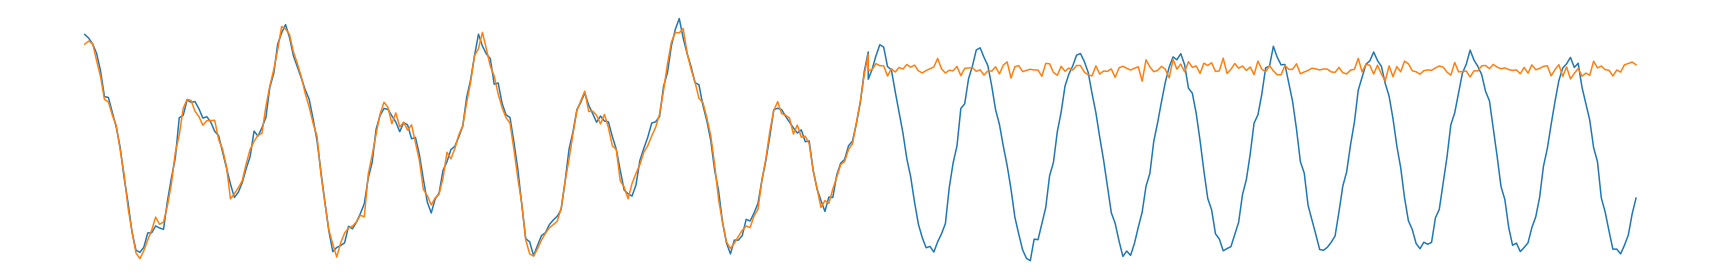

In [42]:
pl.figure(figsize=(24,4))
pl.plot(x,curve1)
pl.plot(x,curve2)
pl.axis('off')
pl.tight_layout()
#pl.savefig("../Figures/NoisyFunConcat.pdf",bbox_inches='tight')

In [43]:
"""### BOTTLENECK ###
B,matching=persim.bottleneck(d1, d2,matching=True)
print("Bottleneck",B)

Pb=np.zeros((d1.shape[0],d2.shape[0]))
Pbs=np.zeros((d1.shape[0],d1.shape[0]))
Pbt=np.zeros((d2.shape[0],d2.shape[0]))
for i in range(matching.shape[0]):
    if matching[i,0]!=-1 and matching[i,1] !=-1:
        Pb[int(matching[i,0]),int(matching[i,1])]=1
    if matching[i,0]==-1:
        Pbt[int(matching[i,1]),int(matching[i,1])]=1
    if matching[i,1]==-1:
        Pbs[int(matching[i,0]),int(matching[i,0])]=1"""

'### BOTTLENECK ###\nB,matching=persim.bottleneck(d1, d2,matching=True)\nprint("Bottleneck",B)\n\nPb=np.zeros((d1.shape[0],d2.shape[0]))\nPbs=np.zeros((d1.shape[0],d1.shape[0]))\nPbt=np.zeros((d2.shape[0],d2.shape[0]))\nfor i in range(matching.shape[0]):\n    if matching[i,0]!=-1 and matching[i,1] !=-1:\n        Pb[int(matching[i,0]),int(matching[i,1])]=1\n    if matching[i,0]==-1:\n        Pbt[int(matching[i,1]),int(matching[i,1])]=1\n    if matching[i,1]==-1:\n        Pbs[int(matching[i,0]),int(matching[i,0])]=1'

In [44]:
"""def f(x):
    return -.2*np.ones(x.shape)

def g(x):
    return -np.exp(-((x/15)**2))-np.exp(-(((x+50)/15)**2))-np.exp(-(((x-50)/15)**2))"""

"""def g(x):
    return 4*(np.sin(1/x)-2*np.cos(x-2)**2+2*np.sin(x/8)**2-np.cos(x))+10*np.sin(x)-5

def h(x):
    h=f(x)
    for i in range(1,100,8):
        h=h-10*np.exp(-(x-i)**2)
    return h"""

'def g(x):\n    return 4*(np.sin(1/x)-2*np.cos(x-2)**2+2*np.sin(x/8)**2-np.cos(x))+10*np.sin(x)-5\n\ndef h(x):\n    h=f(x)\n    for i in range(1,100,8):\n        h=h-10*np.exp(-(x-i)**2)\n    return h'

In [ ]:
"""
a=(50*np.ones(n+1))/n
b=(50*np.ones(m+1))/m
a[-1],b[-1]=50,50

atrue=(50*np.ones(ntrue+1))/ntrue
btrue=(50*np.ones(mtrue+1))/mtrue
atrue[-1],btrue[-1]=50,50
"""